## Setting up:

In [ ]:
import pandas as pd
import os
import warnings
import massbalancemachine as mbm
import pyproj
import matplotlib.pyplot as plt
import seaborn as sns
import xarray as xr
import geopandas as gpd
import logging
import glob
from cmcrameri import cm

from scripts.helpers import *
from scripts.iceland_preprocess import *
from scripts.config_ICE import *

warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2

cfg = mbm.IcelandConfig()

# Module logger
log = logging.getLogger('.'.join(__name__.split('.')[:-1]))

In [2]:
seed_all(cfg.seed)
free_up_cuda()

# Plot styles:
path_style_sheet = 'scripts/example.mplstyle'
plt.style.use(path_style_sheet)

cmap = cm.devon

# For bars and lines:
color_diff_xgb = '#4d4d4d'

colors = get_cmap_hex(cm.batlow, 10)
color_1 = colors[0]
color_2 = '#c51b7d'

### Load all stake csv files into 1 df

In [3]:
all_files = glob.glob(os.path.join(path_PMB_WGMS_raw, "*.csv"))

# Initialize empty list to store dataframes
dfs = []

# Read each CSV file into a dataframe and append to list
for file in all_files:
    df = pd.read_csv(file)
    dfs.append(df)

# Concatenate all dataframes into one
combined_df = pd.concat(dfs, ignore_index=True)

# Print info
print(f"Combined {len(all_files)} CSV files into one dataframe with {len(combined_df)} rows")

display(combined_df.head(2))


Combined 543 CSV files into one dataframe with 3783 rows


,ba_floating_date,ba_stratigraphic,bs_floating_date,bs_stratigraphic,bw_floating_date,bw_stratigraphic,d1,d2,d3,ds,...,lat,lon,nswe_fall,rhos,rhow,snow_melt_fall,stake,swes,swew,yr
0,NaN,NaN,NaN,NaN,1.224,1.224,NaN,1997-06-10,NaN,NaN,...,64.542001,-17.283667,NaN,NaN,450.0,NaN,GL11,NaN,1.224,1997
1,NaN,NaN,-0.531661,-0.741661,NaN,NaN,2007-10-10,2008-06-04,2008-09-29,NaN,...,64.456646,-17.286686,0.21,NaN,NaN,NaN,Gh03b,NaN,NaN,2008


###### Split into annual and winter rows

In [4]:
df_stakes_split = split_stake_measurements(combined_df)

# Convert date columns to string in 'YYYYMMDD' format
df_stakes_split['TO_DATE'] = pd.to_datetime(df_stakes_split['TO_DATE']).dt.strftime('%Y%m%d')
df_stakes_split['FROM_DATE'] = pd.to_datetime(df_stakes_split['FROM_DATE']).dt.strftime('%Y%m%d')

display(df_stakes_split)

display(df_stakes_split[df_stakes_split['TO_DATE'].isna()])

,elevation,lat,lon,stake,FROM_DATE,TO_DATE,POINT_BALANCE,PERIOD,YEAR
0,1744.39,64.555705,-17.410172,Gjal28,20060925,20071010,1.785833,annual,2007.0
1,1594.20,64.529965,-17.007155,D09,NaN,19930928,3.375500,annual,1993.0
2,1591.50,64.530070,-17.008139,D09,19930928,19940916,1.794500,annual,1994.0
3,1590.00,64.530167,-17.009000,D09,NaN,19961001,1.370000,annual,1996.0
4,1586.90,64.530737,-17.009282,D09,19961001,19970825,0.430000,annual,1997.0
...,...,...,...,...,...,...,...,...,...
6593,1127.80,64.714302,-19.073915,hsv11,20141010,20150503,3.230000,winter,2015.0
6594,1125.70,64.714302,-19.073915,hsv11,20151008,20160503,1.650000,winter,2016.0
6595,1512.00,64.423584,-17.248647,SKTH,19990924,20000611,2.766000,winter,2000.0
6596,1542.49,64.437501,-17.399826,Gh15a,NaN,20070605,2.321198,winter,2007.0


,elevation,lat,lon,stake,FROM_DATE,TO_DATE,POINT_BALANCE,PERIOD,YEAR
100,743.00,64.530701,-20.432091,L02,20131119,NaN,-4.9710,annual,2014.0
1046,1522.00,64.378917,-16.081383,BB0,19980926,NaN,1.8580,annual,1999.0
1208,761.04,64.319255,-18.108742,T01,20221027,NaN,-6.6000,annual,2023.0
1405,173.85,64.105975,-16.375490,Br2,20201010,NaN,-9.9300,annual,2021.0
1703,839.45,64.797799,-16.832915,D01,NaN,NaN,-4.9000,annual,2023.0
1778,1197.60,64.740622,-17.051846,D10,19961001,NaN,-1.2005,annual,1997.0
1936,844.00,64.575920,-20.032940,L12,20070925,NaN,-3.8690,annual,2008.0
2843,364.04,64.140565,-16.400018,Br3,20201010,NaN,-7.3500,annual,2021.0


###### Fix NaN dates by adding hydrological year dates. (It would be nicer if this code also checked if there was a previous year of the same stake with a date and then takes that date instead of hydr. year)

In [5]:
display(df_stakes_split[df_stakes_split['FROM_DATE'].isna()])
display(df_stakes_split[df_stakes_split['TO_DATE'].isna()])
display(df_stakes_split[df_stakes_split['YEAR'].isna()])

# Change NaN year values to the year of the TO_DATE
df_stakes_split.loc[df_stakes_split['YEAR'].isna(), 'YEAR'] = df_stakes_split.loc[df_stakes_split['YEAR'].isna(), 'TO_DATE'].astype(str).str[:4].astype(float)

# Set FROM_DATE from NaN to 01 Oct of previous year
df_stakes_split.loc[df_stakes_split['FROM_DATE'].isna(), 'FROM_DATE'] = (
    (df_stakes_split.loc[df_stakes_split['FROM_DATE'].isna(), 'YEAR'].astype(int) - 1).astype(str) + '1001'
)
# Set TO_DATE from NaN to 01 Oct of the year (as only annual rows have NaN)
df_stakes_split.loc[df_stakes_split['TO_DATE'].isna(), 'TO_DATE'] = (
    df_stakes_split.loc[df_stakes_split['TO_DATE'].isna(), 'YEAR'].astype(int).astype(str) + '1001'
)


,elevation,lat,lon,stake,FROM_DATE,TO_DATE,POINT_BALANCE,PERIOD,YEAR
1,1594.200000,64.529965,-17.007155,D09,NaN,19930928,3.375500,annual,1993.0
3,1590.000000,64.530167,-17.009000,D09,NaN,19961001,1.370000,annual,1996.0
7,1572.910000,64.530269,-17.009506,D09,NaN,20051003,0.595000,annual,2005.0
26,1537.700000,64.443660,-17.308348,G02a,NaN,19940830,1.500000,annual,1994.0
54,1175.330444,64.700000,-20.050000,L15,NaN,19971012,0.282500,annual,1997.0
...,...,...,...,...,...,...,...,...,...
6482,865.100000,64.788615,-16.733066,D02,NaN,19930507,0.850000,winter,1993.0
6483,1012.300000,64.792462,-16.764544,D02,NaN,19950501,0.700000,winter,1995.0
6568,1364.900000,64.370383,-17.758666,Tu13,NaN,19860503,1.739000,winter,1986.0
6596,1542.490000,64.437501,-17.399826,Gh15a,NaN,20070605,2.321198,winter,2007.0


,elevation,lat,lon,stake,FROM_DATE,TO_DATE,POINT_BALANCE,PERIOD,YEAR
100,743.00,64.530701,-20.432091,L02,20131119,NaN,-4.9710,annual,2014.0
1046,1522.00,64.378917,-16.081383,BB0,19980926,NaN,1.8580,annual,1999.0
1208,761.04,64.319255,-18.108742,T01,20221027,NaN,-6.6000,annual,2023.0
1405,173.85,64.105975,-16.375490,Br2,20201010,NaN,-9.9300,annual,2021.0
1703,839.45,64.797799,-16.832915,D01,NaN,NaN,-4.9000,annual,2023.0
1778,1197.60,64.740622,-17.051846,D10,19961001,NaN,-1.2005,annual,1997.0
1936,844.00,64.575920,-20.032940,L12,20070925,NaN,-3.8690,annual,2008.0
2843,364.04,64.140565,-16.400018,Br3,20201010,NaN,-7.3500,annual,2021.0


,elevation,lat,lon,stake,FROM_DATE,TO_DATE,POINT_BALANCE,PERIOD,YEAR
3210,1670.00,64.542001,-17.283667,GL11,NaN,19970610,1.224,winter,NaN
3211,1640.00,64.449993,-17.450001,GL7a,NaN,19970825,0.930,winter,NaN
3215,1589.30,64.530834,-17.007278,D09,19940916,19950501,2.170,winter,NaN
3239,1869.84,64.650388,-17.386972,BB08,NaN,20230531,1.840,winter,NaN
3242,1892.00,64.656667,-17.433333,Bafk04,NaN,20150610,2.390,winter,NaN
...,...,...,...,...,...,...,...,...,...
6417,1887.51,64.640160,-17.446367,Barc,NaN,20170608,2.970,winter,NaN
6420,1900.20,64.640148,-17.446338,Barc,20201010,20210608,2.115,winter,NaN
6431,1047.90,64.790063,-18.595688,hsa11,19950915,19960512,1.020,winter,NaN
6535,1444.50,64.869136,-18.867241,hn15,19910912,19920514,3.690,winter,NaN


#### Check for problematic date ranges

In [6]:
annual_inconsistent, winter_inconsistent = check_period_consistency(df_stakes_split)


# Display the inconsistent records
if len(annual_inconsistent) > 0:
    print("\nInconsistent annual periods:")
    display(annual_inconsistent)

if len(winter_inconsistent) > 0:
    print("\nInconsistent winter periods:")
    display(winter_inconsistent)

# Only index 5084 is unreasonabl (-2), probably wrong FROM_DATE year, change to year - 1
df_stakes_split.loc[5084, 'FROM_DATE'] = '19960825'


Annual periods: 0 out of 3210 (0.0%) are inconsistent
Winter periods: 13 out of 3388 (0.4%) are inconsistent

Inconsistent winter periods:


,elevation,lat,lon,stake,FROM_DATE,TO_DATE,POINT_BALANCE,PERIOD,YEAR,FROM_DATE_DT,TO_DATE_DT,MONTH_DIFF
3211,1640.0,64.449993,-17.450001,GL7a,19961001,19970825,0.9300,winter,1997.0,1996-10-01,1997-08-25,10
4239,1411.0,64.416605,-17.336742,Bor,19960830,19970611,2.0000,winter,1997.0,1996-08-30,1997-06-11,10
4240,1380.0,64.415715,-17.336125,Bor,19970826,19980607,1.5915,winter,1998.0,1997-08-26,1998-06-07,10
4241,1385.0,64.415667,-17.336017,Bor,19980825,19990606,2.6920,winter,1999.0,1998-08-25,1999-06-06,10
4525,1970.0,64.639364,-17.523302,K06,19970825,19980615,1.9165,winter,1998.0,1997-08-25,1998-06-15,10
4526,1970.0,64.639217,-17.523233,K06,19980826,19990610,2.1760,winter,1999.0,1998-08-26,1999-06-10,10
4552,1825.0,63.996503,-16.650666,Oer01,19931001,19940829,7.7800,winter,1994.0,1993-10-01,1994-08-29,10
4553,1825.0,63.996503,-16.650666,Oer01,19940829,19950611,5.7500,winter,1995.0,1994-08-29,1995-06-11,10
5261,1770.0,64.566674,-17.466664,GL10,19961001,19970825,1.2000,winter,1997.0,1996-10-01,1997-08-25,10
5536,1635.0,64.583004,-17.265992,GL10a,19970825,19970610,1.4985,winter,1997.0,1997-08-25,1997-06-10,-2


###### Rename Columns, we can skip the close stake removal, as seen form the leaflet map online, the stakes are spaced out.

In [7]:
df_stakes_renamed = df_stakes_split.rename(columns={
    'lat': 'POINT_LAT', 
    'lon': 'POINT_LON',
    'elevation': 'POINT_ELEVATION',
    'stake': 'ID',
})

##### Find RGIId

In [8]:
## If initialize_oggm_glacier_directories() hasnt been executed yet, get the shapefile with this
#utils.get_rgi_region_file(region="06", version="6")

# Load glacier outlines
glacier_outline = gpd.read_file('/home/mburlet/OGGM/rgi/RGIV60/06_rgi60_Iceland/06_rgi60_Iceland.shp')

# Add RGI IDs through intersection
df_stakes_renamed_rgiid = mbm.data_processing.utils.get_rgi(data=df_stakes_renamed,
                                           glacier_outlines=glacier_outline)

display(df_stakes_renamed_rgiid[df_stakes_renamed_rgiid['RGIId'].isna()])
# Remove (nine) stakes without RGIId, as they wont have OGGM data anyways
df_stakes_renamed_rgiid = df_stakes_renamed_rgiid.dropna(subset=['RGIId'])

,POINT_ELEVATION,POINT_LAT,POINT_LON,ID,FROM_DATE,TO_DATE,POINT_BALANCE,PERIOD,YEAR,RGIId
1549,490.0,64.492780,-20.43633,L01,19971012,19980916,-7.0300,annual,1998.0,NaN
1550,505.0,64.493820,-20.43648,L01,19980916,19990928,-4.9500,annual,1999.0,NaN
1551,490.0,64.493430,-20.43622,L01,19990928,20001004,-5.4825,annual,2000.0,NaN
1552,485.0,64.493820,-20.43647,L01,20001004,20011005,-6.3615,annual,2001.0,NaN
4842,490.0,64.492780,-20.43633,L01,19971012,19980417,0.2900,winter,1998.0,NaN
4843,505.0,64.493820,-20.43648,L01,19980916,19990422,1.6690,winter,1999.0,NaN
4844,490.0,64.493430,-20.43622,L01,19990928,20000427,1.3200,winter,2000.0,NaN
4845,485.0,64.493820,-20.43647,L01,20001004,20010419,0.8845,winter,2001.0,NaN
6333,715.0,64.776661,-16.05650,B08,19940915,19950503,0.5400,winter,1995.0,NaN


#### Add OGGM data

In [9]:
# initialize OGGM glacier directories
gdirs, rgidf = initialize_oggm_glacier_directories(
    working_dir= path_OGGM,
    rgi_region="06", #06 iceland
    rgi_version="6",
    base_url=
    "https://cluster.klima.uni-bremen.de/~oggm/gdirs/oggm_v1.6/L3-L5_files/2023.1/elev_bands/W5E5_w_data/",
    log_level='WARNING',
    task_list=None,
)


unique_rgis = df_stakes_renamed_rgiid['RGIId'].unique()

run = True
if run:
    export_oggm_grids(gdirs, subset_rgis=unique_rgis, output_path=path_OGGM_xrgrids)

## Around 10% of all the measurements have no hugonnet_dhdt data, so I removed the entire variable from merge_pmb_with_oggm_data()
df_stakes_topo = merge_pmb_with_oggm_data(df_pmb=df_stakes_renamed_rgiid,
                                       gdirs=gdirs,
                                       rgi_region="06", #06 iceland
                                       rgi_version="6")
                                       


2025-06-03 13:25:01: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2025-06-03 13:25:01: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2025-06-03 13:25:01: oggm.cfg: Multiprocessing: using all available processors (N=12)
2025-06-03 13:25:01: oggm.cfg: PARAMS['border'] changed from `80` to `10`.
2025-06-03 13:25:01: oggm.cfg: Multiprocessing switched ON after user settings.
2025-06-03 13:25:01: oggm.cfg: PARAMS['continue_on_error'] changed from `False` to `True`.
2025-06-03 13:25:01: oggm.workflow: init_glacier_directories from prepro level 3 on 568 glaciers.
2025-06-03 13:25:01: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 568 glaciers
  0% of 129.0 MiB |                      | Elapsed Time: 0:00:00 ETA:  --:--:--
  9% of 129.0 MiB |##                    | Elapsed Time: 0:00:17 ETA:   0:02:52
 17% of 129.0 MiB |###                   | Elapsed Time: 0:00:32 ETA:   0:02:29
 27% of 129.0 MiB |#####                

###### Get Glacier names from RGIId

In [10]:
# Create a dictionary mapping from RGIId to glacier name
rgi_to_name_dict = dict(zip(rgidf.RGIId, rgidf.Name))
df_stakes_topo['GLACIER'] = df_stakes_topo['RGIId'].map(rgi_to_name_dict)


display(df_stakes_topo[df_stakes_topo['GLACIER'].isna()])


,POINT_ELEVATION,POINT_LAT,POINT_LON,ID,FROM_DATE,TO_DATE,POINT_BALANCE,PERIOD,YEAR,RGIId,aspect,slope,topo,consensus_ice_thickness,millan_v,within_glacier_shape,GLACIER
54,1175.330444,64.700000,-20.050000,L15,19961001,19971012,0.2825,annual,1997.0,RGI60-06.00303,316.579186,1.546897,1153.062378,163.393127,9.938813,True,None
189,1237.880000,63.791341,-19.588796,Tin02,20211001,20220904,0.2820,annual,2022.0,RGI60-06.00359,303.527487,2.235954,1234.808838,80.359573,10.037036,True,None
190,928.200000,64.965547,-18.917728,hn9v,19900913,19910912,-4.0700,annual,1991.0,RGI60-06.00238,337.359900,3.783690,858.737183,115.771072,5.863248,True,None
191,925.000000,64.965547,-18.917728,hn9v,19910912,19920920,-2.0800,annual,1992.0,RGI60-06.00238,337.359900,3.783690,858.737183,115.771072,5.863248,True,None
192,921.900000,64.965547,-18.917728,hn9v,19920920,19930915,-0.5400,annual,1993.0,RGI60-06.00238,337.359900,3.783690,858.737183,115.771072,5.863248,True,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6563,1437.000000,64.869136,-18.867241,hn15,20191105,20200502,2.3400,winter,2020.0,RGI60-06.00238,356.037899,4.534064,1423.256226,186.849655,35.753441,True,None
6564,1437.000000,64.869136,-18.867241,hn15,20201009,20210502,2.3300,winter,2021.0,RGI60-06.00238,356.037899,4.534064,1423.256226,186.849655,35.753441,True,None
6565,1437.000000,64.869136,-18.867241,hn15,20211021,20220427,3.0200,winter,2022.0,RGI60-06.00238,356.037899,4.534064,1423.256226,186.849655,35.753441,True,None
6566,1437.000000,64.869136,-18.867241,hn15,20221018,20230427,2.3000,winter,2023.0,RGI60-06.00238,356.037899,4.534064,1423.256226,186.849655,35.753441,True,None


###### Multiple RGIIds have no associated glacier name, assign the 'RGIId' as the 'GLACIER' name

In [11]:
missing_rgi_ids = df_stakes_topo.loc[df_stakes_topo['GLACIER'].isna(), 'RGIId'].unique()
print(f"Number of unique RGI IDs without names: {len(missing_rgi_ids)}")
print("RGI IDs without names:", missing_rgi_ids)

# Just assign RGIId to 'GLACIER' as name for the ones that are missing
df_stakes_topo.loc[df_stakes_topo['GLACIER'].isna(), 'GLACIER'] = df_stakes_topo.loc[df_stakes_topo['GLACIER'].isna(), 'RGIId']

Number of unique RGI IDs without names: 32
RGI IDs without names: ['RGI60-06.00303' 'RGI60-06.00359' 'RGI60-06.00238' 'RGI60-06.00466'
 'RGI60-06.00232' 'RGI60-06.00411' 'RGI60-06.00422' 'RGI60-06.00292'
 'RGI60-06.00328' 'RGI60-06.00340' 'RGI60-06.00294' 'RGI60-06.00302'
 'RGI60-06.00311' 'RGI60-06.00320' 'RGI60-06.00478' 'RGI60-06.00465'
 'RGI60-06.00301' 'RGI60-06.00305' 'RGI60-06.00409' 'RGI60-06.00480'
 'RGI60-06.00476' 'RGI60-06.00413' 'RGI60-06.00350' 'RGI60-06.00349'
 'RGI60-06.00228' 'RGI60-06.00342' 'RGI60-06.00425' 'RGI60-06.00306'
 'RGI60-06.00479' 'RGI60-06.00445' 'RGI60-06.00296' 'RGI60-06.00474']


RGI60-06.00234


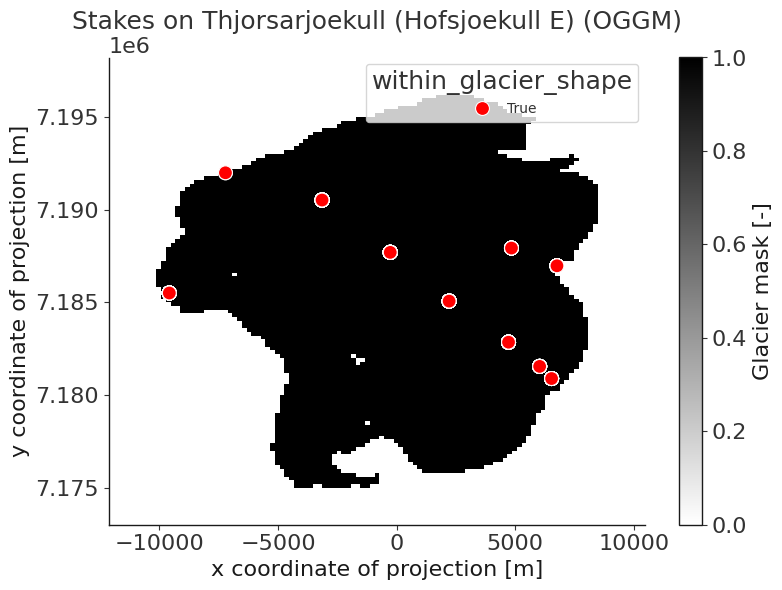

In [ ]:
# Example:
glacierName = 'Thjorsarjoekull (Hofsjoekull E)'
# stakes
df_stakes_topo_1 = df_stakes_topo.copy()
df_stakes_topo_1 = df_stakes_topo_1[(df_stakes_topo_1['GLACIER'] == glacierName)]
RGIId = df_stakes_topo_1['RGIId'].unique()[0]
print(RGIId)
# open OGGM xr for glacier
# Get oggm data for that RGI grid
ds_oggm = xr.open_dataset(f'{path_OGGM_xrgrids}/{RGIId}.zarr')

# Define the coordinate transformation
transf = pyproj.Transformer.from_proj(
    pyproj.CRS.from_user_input("EPSG:4326"),  # Input CRS (WGS84)
    pyproj.CRS.from_user_input(ds_oggm.pyproj_srs),  # Output CRS from dataset
    always_xy=True)

# Transform all coordinates in the group
lon, lat = df_stakes_topo_1["POINT_LON"].values, df_stakes_topo_1["POINT_LAT"].values
x_stake, y_stake = transf.transform(lon, lat)
df_stakes_topo_1['x'] = x_stake
df_stakes_topo_1['y'] = y_stake

# plot stakes
plt.figure(figsize=(8, 6))
ds_oggm.glacier_mask.plot(cmap='binary')
sns.scatterplot(df_stakes_topo_1,
                x='x',
                y='y',
                hue='within_glacier_shape',
                palette=['r', 'b'])
plt.title(f'Stakes on {glacierName} (OGGM)')
plt.tight_layout()

In [14]:
# Restrict to within glacier shape
df_stakes_topo = df_stakes_topo[df_stakes_topo['within_glacier_shape'] == True]
df_stakes_topo = df_stakes_topo.drop(columns=['within_glacier_shape'])

# Display rows that have any NaN values
display(df_stakes_topo[df_stakes_topo.isna().any(axis=1)])

# Fill NaN values in POINT_ELEVATION with values from topo for 30 rows
df_stakes_topo.loc[df_stakes_topo['POINT_ELEVATION'].isna(), 'POINT_ELEVATION'] = df_stakes_topo.loc[df_stakes_topo['POINT_ELEVATION'].isna(), 'topo']

# Drop 4 rows where consensus_ice_thickness is NaN
df_stakes_topo_dropped = df_stakes_topo.dropna(subset=['consensus_ice_thickness'])

display(len(df_stakes_topo_dropped[df_stakes_topo_dropped['consensus_ice_thickness'].isna()]))
display(len(df_stakes_topo_dropped[df_stakes_topo_dropped['POINT_ELEVATION'].isna()]))


,POINT_ELEVATION,POINT_LAT,POINT_LON,ID,FROM_DATE,TO_DATE,POINT_BALANCE,PERIOD,YEAR,RGIId,aspect,slope,topo,consensus_ice_thickness,millan_v,GLACIER
266,NaN,64.662707,-18.954942,blt8,20231024,20241106,-3.790,annual,2024.0,RGI60-06.00232,201.661595,3.887532,838.149109,210.906982,4.487715,RGI60-06.00232
741,NaN,64.836450,-18.871219,hn17,20231025,20241106,2.230,annual,2024.0,RGI60-06.00238,15.440877,2.951443,1683.188843,283.531555,44.236687,RGI60-06.00238
953,NaN,64.934272,-18.846087,hn12,20231025,20241104,-1.060,annual,2024.0,RGI60-06.00238,323.152970,3.079840,1158.750488,252.628937,9.670280,RGI60-06.00238
1041,NaN,64.749711,-19.000955,hsv15,20231024,20241106,1.370,annual,2024.0,RGI60-06.00236,245.700865,4.345945,1467.363892,292.617218,23.039806,Blagnipujoekull (Hofsjoekull SW)
1245,NaN,64.921358,-18.834673,hn13,20231025,20241104,-1.240,annual,2024.0,RGI60-06.00238,14.543962,1.944955,1242.181152,286.144684,14.929413,RGI60-06.00238
1516,NaN,64.687726,-18.954530,blt11,20231024,20241106,-1.700,annual,2024.0,RGI60-06.00232,192.688338,3.780383,1077.508667,201.788971,34.596584,RGI60-06.00232
1553,486.0,64.494360,-20.435610,L01,20011005,20021031,-7.371,annual,2002.0,RGI60-06.00291,224.979505,1.592727,479.944916,NaN,0.000000,Hagafellsjoekull West
1685,NaN,64.838974,-18.708493,hsa15,20231024,20241104,1.230,annual,2024.0,RGI60-06.00234,105.413192,2.308865,1450.369507,448.350372,48.769199,Thjorsarjoekull (Hofsjoekull E)
1775,NaN,64.783235,-18.833478,hsa16,20231024,20241106,1.790,annual,2024.0,RGI60-06.00237,150.740226,4.326712,1604.321167,367.209534,101.149162,Mulajoekull
1816,NaN,64.957680,-18.860046,hn11,20231025,20241104,-2.600,annual,2024.0,RGI60-06.00238,347.548357,3.425522,1043.424805,205.175507,5.888263,RGI60-06.00238


0

0

In [15]:
display(df_stakes_topo_dropped.head(2))
# Create new POINT_ID column
df_stakes_topo_dropped['POINT_ID'] = (
    df_stakes_topo_dropped['GLACIER'] + '_' + 
    df_stakes_topo_dropped['YEAR'].astype(str) + '_' + 
    df_stakes_topo_dropped['PERIOD'].astype(str) + '_' +
    df_stakes_topo_dropped['ID'].astype(str)
)

df_stakes_topo_dropped = df_stakes_topo_dropped.drop(columns=['ID'])

display(df_stakes_topo_dropped.head(2))

,POINT_ELEVATION,POINT_LAT,POINT_LON,ID,FROM_DATE,TO_DATE,POINT_BALANCE,PERIOD,YEAR,RGIId,aspect,slope,topo,consensus_ice_thickness,millan_v,GLACIER
0,1744.39,64.555705,-17.410172,Gjal28,20060925,20071010,1.785833,annual,2007.0,RGI60-06.00475,151.898407,0.876541,1740.480713,488.543335,26.53290,Skeidararjoekull
1,1594.20,64.529965,-17.007155,D09,19921001,19930928,3.375500,annual,1993.0,RGI60-06.00477,10.779899,1.033374,1573.148926,589.661133,40.94659,Dyngjujoekull


,POINT_ELEVATION,POINT_LAT,POINT_LON,FROM_DATE,TO_DATE,POINT_BALANCE,PERIOD,YEAR,RGIId,aspect,slope,topo,consensus_ice_thickness,millan_v,GLACIER,POINT_ID
0,1744.39,64.555705,-17.410172,20060925,20071010,1.785833,annual,2007.0,RGI60-06.00475,151.898407,0.876541,1740.480713,488.543335,26.53290,Skeidararjoekull,Skeidararjoekull_2007.0_annual_Gjal28
1,1594.20,64.529965,-17.007155,19921001,19930928,3.375500,annual,1993.0,RGI60-06.00477,10.779899,1.033374,1573.148926,589.661133,40.94659,Dyngjujoekull,Dyngjujoekull_1993.0_annual_D09


In [16]:
output_path = (path_PMB_WGMS_csv + 'ICE_dataset_all_oggm.csv')
df_stakes_topo_dropped.to_csv(output_path, index=False)